In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from prophet import Prophet
import pandas as pd
import numpy as np

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import sys  
sys.path.insert(0, '../../')
import RadonDF_Handler

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [45]:
D001_df = pd.read_csv('./../../../../../Data/SensorsData/interpolated_D001_data.csv')
D001_df = D001_df.iloc[913:]
D001_df
D001_df['time'] =  pd.to_datetime(D001_df['time'], format='%Y-%m-%d %H:%M:%S')
D001_df.rename(columns = {'Rn':'y','time':'ds'}, inplace = True)
D001_df[T]
D001_df = D001_df.reset_index(drop=True)
D001_df
# D001_df.index = D001_df['time']
# D001_df = D001_df.drop(['time'],axis = 1)
# D001_df.index = D001_df.index.rename('ds')
# D001_df.rename(columns = {'Rn':'y'}, inplace = True)
# D001_columns = list(D001_df.columns)
# D001_columns[0],D001_columns[1] = D001_columns[1],D001_columns[0]
# D001_df = D001_df[D001_columns]

,ds,T,y,H,P,CO2
0,2019-07-05 15:00:00,33.304737,10.995556,32.315789,101.571263,29.263158
1,2019-07-05 16:00:00,33.566316,10.340526,33.157895,101.553895,28.894737
2,2019-07-05 17:00:00,33.453500,9.654000,32.050000,101.534200,28.150000
3,2019-07-05 18:00:00,33.578947,10.009474,32.526316,101.527526,28.789474
4,2019-07-05 19:00:00,33.745789,13.413684,32.947368,101.523500,29.684211
...,...,...,...,...,...,...
8542,2021-08-18 08:00:00,22.772000,145.034000,60.800000,101.978200,138.800000
8543,2021-08-18 09:00:00,22.665000,226.328000,61.500000,101.960600,137.400000
8544,2021-08-18 10:00:00,22.703750,247.572500,60.875000,101.922750,136.375000
8545,2021-08-23 08:00:00,23.290000,330.400000,63.000000,101.663000,169.000000


In [46]:
D001_df

,ds,T,y,H,P,CO2
0,2019-07-05 15:00:00,33.304737,10.995556,32.315789,101.571263,29.263158
1,2019-07-05 16:00:00,33.566316,10.340526,33.157895,101.553895,28.894737
2,2019-07-05 17:00:00,33.453500,9.654000,32.050000,101.534200,28.150000
3,2019-07-05 18:00:00,33.578947,10.009474,32.526316,101.527526,28.789474
4,2019-07-05 19:00:00,33.745789,13.413684,32.947368,101.523500,29.684211
...,...,...,...,...,...,...
8542,2021-08-18 08:00:00,22.772000,145.034000,60.800000,101.978200,138.800000
8543,2021-08-18 09:00:00,22.665000,226.328000,61.500000,101.960600,137.400000
8544,2021-08-18 10:00:00,22.703750,247.572500,60.875000,101.922750,136.375000
8545,2021-08-23 08:00:00,23.290000,330.400000,63.000000,101.663000,169.000000


In [47]:
trainData, testData = train_test_split(D001_df, test_size=0.2,shuffle=False)
testData = testData.reset_index(drop=True)

testData_v2 = testData[['ds','T','H','P','CO2']]
testData_v2 = testData.reset_index(drop=True)

In [48]:
testData

,ds,T,y,H,P,CO2
0,2021-05-13 18:00:00,21.445000,912.045000,70.250000,101.860333,15.250000
1,2021-05-13 19:00:00,21.347500,853.960000,62.250000,101.879000,15.750000
2,2021-05-24 22:00:00,20.415000,90.156667,65.000000,102.825200,43.666667
3,2021-05-25 00:00:00,21.099000,68.766000,54.800000,102.829900,46.200000
4,2021-05-25 01:00:00,20.942727,79.580000,54.636364,102.819909,46.090909
...,...,...,...,...,...,...
1705,2021-08-18 08:00:00,22.772000,145.034000,60.800000,101.978200,138.800000
1706,2021-08-18 09:00:00,22.665000,226.328000,61.500000,101.960600,137.400000
1707,2021-08-18 10:00:00,22.703750,247.572500,60.875000,101.922750,136.375000
1708,2021-08-23 08:00:00,23.290000,330.400000,63.000000,101.663000,169.000000


In [49]:
model = Prophet(yearly_seasonality=True)
model.add_regressor('T',standardize = False)
model.add_regressor('H',standardize = False)
model.add_regressor('P',standardize = False)
model.add_regressor('CO2',standardize = False)

In [50]:
model.fit(trainData)

C:\Users\valdo\anaconda3\envs\RnHealth\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [51]:
forecast = model.predict(testData_v2)
forecast = forecast[['ds','yhat']]

C:\Users\valdo\anaconda3\envs\RnHealth\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\valdo\anaconda3\envs\RnHealth\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [52]:
testData

,ds,T,y,H,P,CO2
0,2021-05-13 18:00:00,21.445000,912.045000,70.250000,101.860333,15.250000
1,2021-05-13 19:00:00,21.347500,853.960000,62.250000,101.879000,15.750000
2,2021-05-24 22:00:00,20.415000,90.156667,65.000000,102.825200,43.666667
3,2021-05-25 00:00:00,21.099000,68.766000,54.800000,102.829900,46.200000
4,2021-05-25 01:00:00,20.942727,79.580000,54.636364,102.819909,46.090909
...,...,...,...,...,...,...
1705,2021-08-18 08:00:00,22.772000,145.034000,60.800000,101.978200,138.800000
1706,2021-08-18 09:00:00,22.665000,226.328000,61.500000,101.960600,137.400000
1707,2021-08-18 10:00:00,22.703750,247.572500,60.875000,101.922750,136.375000
1708,2021-08-23 08:00:00,23.290000,330.400000,63.000000,101.663000,169.000000


In [53]:
forecast

,ds,yhat
0,2021-05-13 18:00:00,141.621049
1,2021-05-13 19:00:00,98.612273
2,2021-05-24 22:00:00,89.434477
3,2021-05-25 00:00:00,51.361511
4,2021-05-25 01:00:00,51.106369
...,...,...
1705,2021-08-18 08:00:00,251.269146
1706,2021-08-18 09:00:00,258.655782
1707,2021-08-18 10:00:00,259.150777
1708,2021-08-23 08:00:00,428.295523


In [54]:
comparation_df = pd.concat((pd.DataFrame(forecast['yhat']),testData),axis = 1)

In [55]:
comparation_df 

,yhat,ds,T,y,H,P,CO2
0,141.621049,2021-05-13 18:00:00,21.445000,912.045000,70.250000,101.860333,15.250000
1,98.612273,2021-05-13 19:00:00,21.347500,853.960000,62.250000,101.879000,15.750000
2,89.434477,2021-05-24 22:00:00,20.415000,90.156667,65.000000,102.825200,43.666667
3,51.361511,2021-05-25 00:00:00,21.099000,68.766000,54.800000,102.829900,46.200000
4,51.106369,2021-05-25 01:00:00,20.942727,79.580000,54.636364,102.819909,46.090909
...,...,...,...,...,...,...,...
1705,251.269146,2021-08-18 08:00:00,22.772000,145.034000,60.800000,101.978200,138.800000
1706,258.655782,2021-08-18 09:00:00,22.665000,226.328000,61.500000,101.960600,137.400000
1707,259.150777,2021-08-18 10:00:00,22.703750,247.572500,60.875000,101.922750,136.375000
1708,428.295523,2021-08-23 08:00:00,23.290000,330.400000,63.000000,101.663000,169.000000


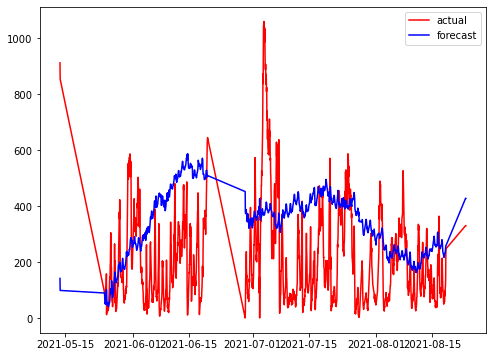

In [56]:
plt.figure(figsize=(8,6))
plt.plot(comparation_df['ds'],comparation_df['y'],color = 'red',label = 'actual')
plt.plot(comparation_df['ds'],comparation_df['yhat'],color = 'blue',label = 'forecast')
plt.legend()